# Estimating uncertainty in abundance

### some preparation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['mathtext.default'] = 'regular'
mpl.rcParams['font.size'] = 14
mpl.rcParams['axes.titlesize'] = 20

In [2]:
zinser_fig3 = pd.read_csv('Zinser_Figure3.csv')
zinser_fig2a = pd.read_csv('Zinser_Figure2A.csv')

obs_time_hours = zinser_fig2a['exper time'].values

zinser_fig2a

,exper time,cells A,cells B,FALS,time of day
0,0,6.346000e+07,6.503348e+07,0.1838,8
1,2,6.821390e+07,6.512750e+07,0.2147,10
2,4,6.871540e+07,6.523250e+07,0.2640,12
3,6,6.129510e+07,6.298554e+07,0.3314,14
4,8,6.547930e+07,6.597570e+07,0.3950,16
5,10,6.468750e+07,6.559250e+07,0.4416,18
6,12,7.017000e+07,7.009750e+07,0.4033,20
7,14,7.907500e+07,8.327500e+07,0.3108,22
8,16,8.929500e+07,9.382750e+07,0.2448,0
9,18,1.049125e+08,1.045200e+08,0.2020,2


### compute average squared deviation from the mean

 * the mean is estimated based on the two meansurements at each time point
 * `correct_abundance_mean` will correct the estimate of the mean, so that it is not permitted to decrease with time
 * `scale_error_with_signal` assumes that the deviation from the mean scales (linearly) with the signal
 * use `sample_numavg` samples from `abundance_sample` to create `abundance_mean_sample`

In [3]:
correct_abundance_mean = True
scale_error_with_signal = True
num_samples = 10_000
sample_numavg = 2

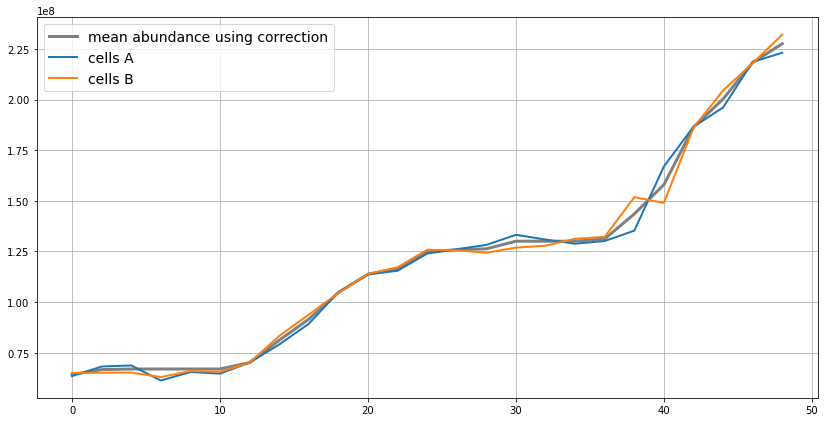

In [4]:
abundance_mean = 0.5 * (zinser_fig2a['cells A'].values + zinser_fig2a['cells B'].values)
# keep a copy of the uncorrected mean for later
abundance_mean_uncorrected = abundance_mean.copy()

if correct_abundance_mean:
    for i in range(1, abundance_mean.size):
        abundance_mean[i] = max(abundance_mean[i-1], abundance_mean[i])

fig, ax = plt.subplots(figsize=(14,7))
ax.plot(obs_time_hours, abundance_mean, label='mean abundance'+('',' using correction')[correct_abundance_mean], lw=3, color='0.5')
ax.plot(obs_time_hours, zinser_fig2a['cells A'], label='cells A', lw=2)
ax.plot(obs_time_hours, zinser_fig2a['cells B'], label='cells B', lw=2)
ax.legend()
ax.grid(True)

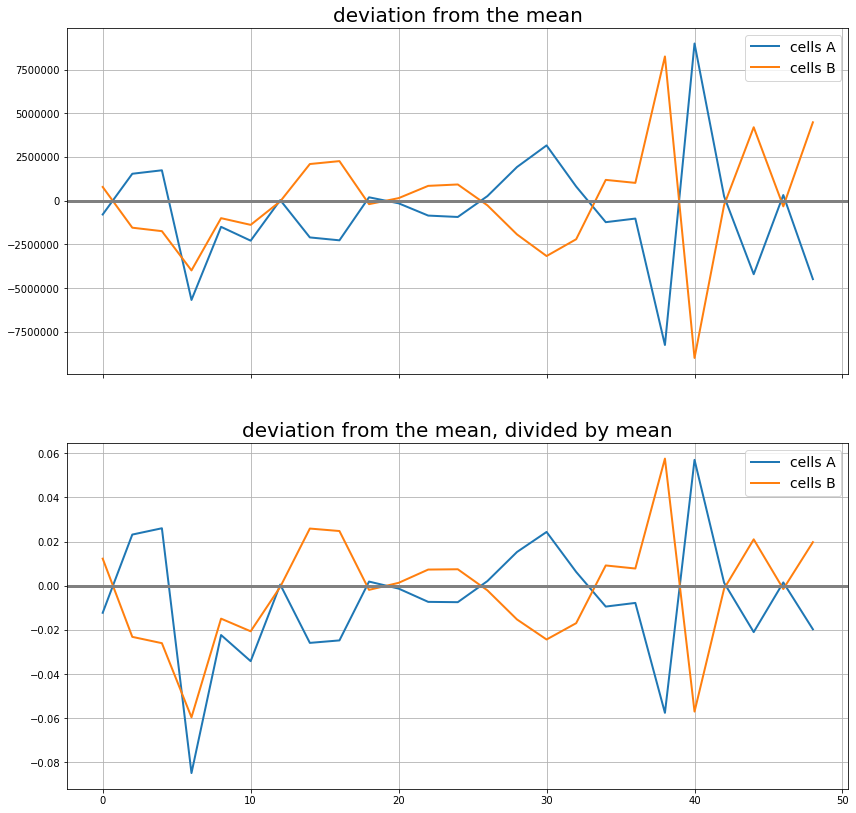

In [5]:
fig, axs = plt.subplots(nrows=2, figsize=(14,2*7), sharex=True)
ax = axs[0]
ax.plot(obs_time_hours, zinser_fig2a['cells A']-abundance_mean, label='cells A', lw=2)
ax.plot(obs_time_hours, zinser_fig2a['cells B']-abundance_mean, label='cells B', lw=2)
ax.set_title('deviation from the mean')

ax = axs[1]
ax.plot(obs_time_hours, (zinser_fig2a['cells A']-abundance_mean)/abundance_mean, label='cells A', lw=2)
ax.plot(obs_time_hours, (zinser_fig2a['cells B']-abundance_mean)/abundance_mean, label='cells B', lw=2)
ax.set_title('deviation from the mean, divided by mean')

for ax in axs:
    ax.axhline(0.0, lw=3, color='0.5')
    ax.legend()
    ax.grid(True)
None

In [6]:
diff_a = zinser_fig2a['cells A'] - abundance_mean
diff_b = zinser_fig2a['cells B'] - abundance_mean

if scale_error_with_signal:
    diff_a /= abundance_mean
    diff_b /= abundance_mean

sd_abundance = np.sqrt((np.sum(diff_a**2) + np.sum(diff_b**2))/(2 * diff_a.size - 1))

if scale_error_with_signal:
    sd_abundance *= abundance_mean

In [7]:
abundance_sample = abundance_mean + sd_abundance * np.random.normal(size=(sample_numavg, num_samples, abundance_mean.size))
abundance_mean_sample = np.mean(abundance_sample, axis=0)

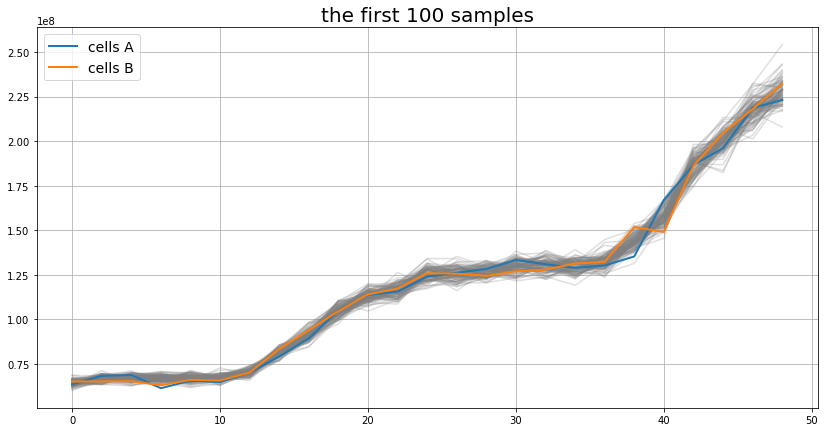

In [8]:
fig, ax = plt.subplots(figsize=(14,7))
ax.plot(obs_time_hours, abundance_sample[0,:100,:].T, color='0.5', alpha=0.25)
ax.plot(obs_time_hours, zinser_fig2a['cells A'], label='cells A', lw=2)
ax.plot(obs_time_hours, zinser_fig2a['cells B'], label='cells B', lw=2)
ax.legend()
ax.grid(True)
ax.set_title('the first 100 samples')
None

# division

### computing average daily division rate

In [9]:
def compute_dailydiv(abundance, num_days=2):
    return np.log(abundance[...,-1] / abundance[...,0])/num_days

for iday in range(2):
    i0 = iday * 12
    i1 = (iday + 1) * 12 + 1
    daily_division_sample = compute_dailydiv(abundance_mean_sample[:,i0:i1], num_days=1)
    print('''
daily division rate day {}:
   cells A: {:.3f}
   cells B: {:.3f}
      mean: {:.3f}
    sample: {:.3f} ± {:.3f} (mean ± sd)'''.format(
        iday + 1,
        compute_dailydiv(zinser_fig2a['cells A'].values[i0:i1], num_days=1),
        compute_dailydiv(zinser_fig2a['cells B'].values[i0:i1], num_days=1),
        compute_dailydiv(abundance_mean[i0:i1], num_days=1),
        np.mean(daily_division_sample), np.std(daily_division_sample)))

daily_division_sample = compute_dailydiv(abundance_mean_sample)

print('''
average daily division rate:
   cells A: {:.3f}
   cells B: {:.3f}
      mean: {:.3f}
    sample: {:.3f} ± {:.3f} (mean ± sd)'''.format(
    compute_dailydiv(zinser_fig2a['cells A'].values),
    compute_dailydiv(zinser_fig2a['cells B'].values),
    compute_dailydiv(abundance_mean),
    np.mean(daily_division_sample), np.std(daily_division_sample)))


daily division rate day 1:
   cells A: 0.669
   cells B: 0.660
      mean: 0.665
    sample: 0.664 ± 0.027 (mean ± sd)

daily division rate day 2:
   cells A: 0.588
   cells B: 0.612
      mean: 0.600
    sample: 0.600 ± 0.027 (mean ± sd)

average daily division rate:
   cells A: 0.629
   cells B: 0.636
      mean: 0.632
    sample: 0.632 ± 0.014 (mean ± sd)


### computing hourly division

In [10]:
def compute_hourly_div(abundance):
    return np.log(abundance[...,1:] / abundance[...,:-1]) / (obs_time_hours[1:] - obs_time_hours[:-1])

division_cellsA = compute_hourly_div(zinser_fig2a['cells A'].values)
division_cellsB = compute_hourly_div(zinser_fig2a['cells B'].values)
division_mean = compute_hourly_div(abundance_mean)

division_sample = compute_hourly_div(abundance_mean_sample)

obs_time_division = 0.5 * (obs_time_hours[1:] + obs_time_hours[:-1])

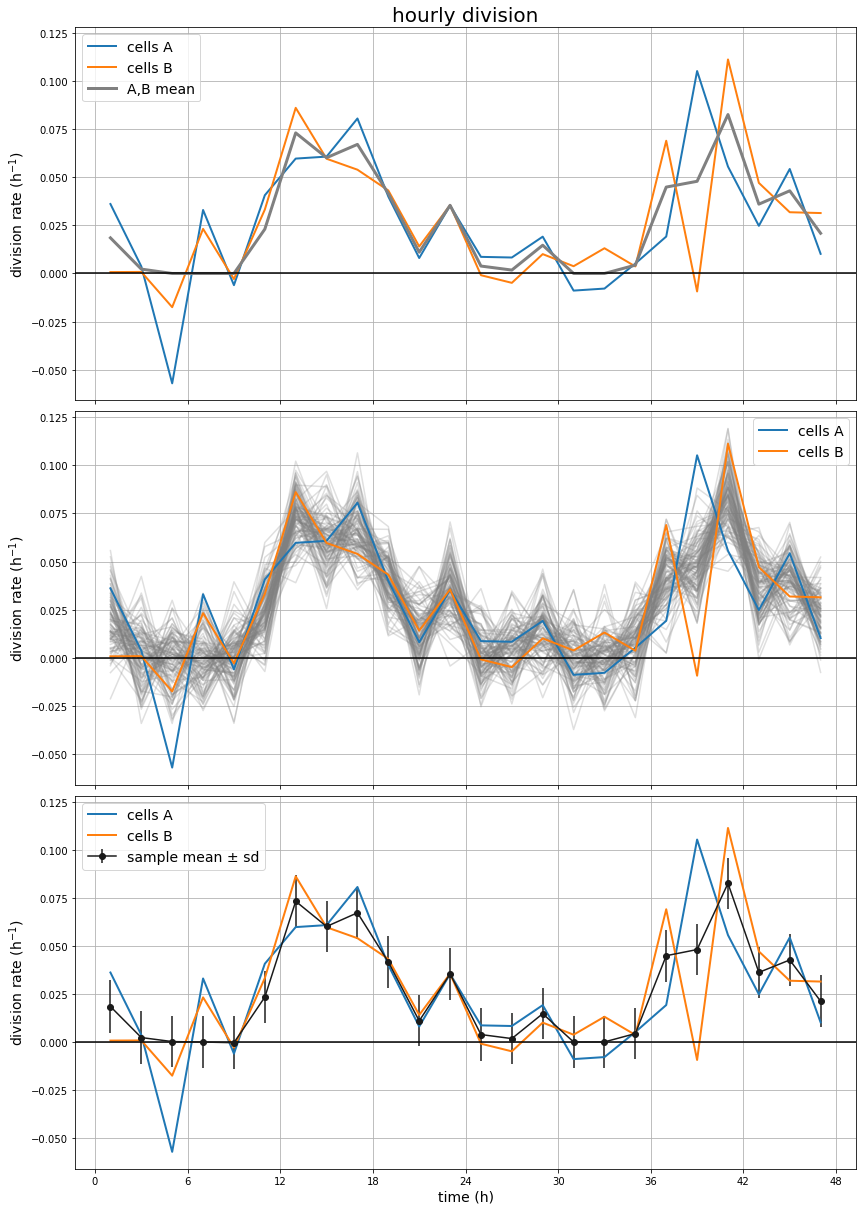

In [11]:
fig, axs = plt.subplots(nrows=3, figsize=(14,3*7), sharex=True, sharey=True, gridspec_kw={'hspace':0.03})
ax = axs[0]
ax.plot(obs_time_division, division_cellsA, label='cells A', lw=2)
ax.plot(obs_time_division, division_cellsB, label='cells B', lw=2)
ax.plot(obs_time_division, division_mean, label='A,B mean', lw=3, color='0.5')
ax.set_title('hourly division')

ax = axs[1]
ax.plot(obs_time_division, division_sample[:100,:].T, color='0.5', alpha=0.25)
ax.plot(obs_time_division, division_cellsA, label='cells A', lw=2)
ax.plot(obs_time_division, division_cellsB, label='cells B', lw=2)

ax = axs[2]
ax.set(xlabel='time (h)', xticks=np.arange(0,50,6))
ax.errorbar(obs_time_division, np.mean(division_sample, axis=0), yerr=np.std(division_sample, axis=0), 
            marker='o', color='0.1', label='sample mean ± sd')
ax.plot(obs_time_division, division_cellsA, label='cells A', lw=2)
ax.plot(obs_time_division, division_cellsB, label='cells B', lw=2)

for ax in axs:
    ax.axhline(0, color='black')
    ax.legend()
    ax.grid(True)
    ax.set(ylabel='division rate (h$^{-1}$)')

### a quick comparison with the smoothed mean (which we have used so far)

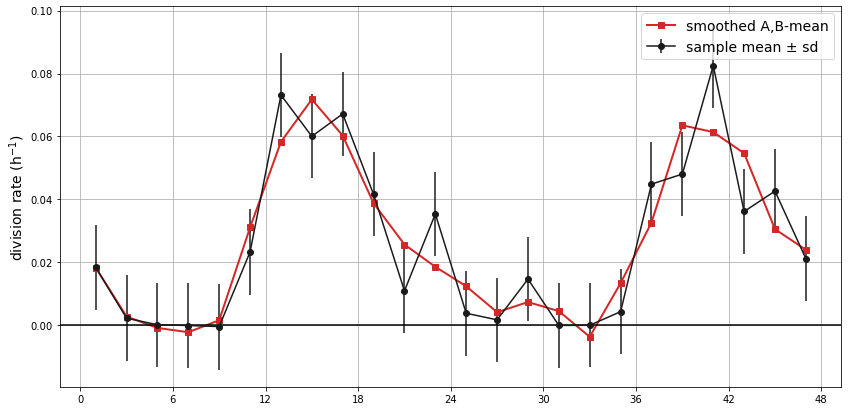

In [12]:
from scipy.signal import savgol_filter
division_mean_smoothed = savgol_filter(division_mean, 5, 3)

fig, ax = plt.subplots(figsize=(14,7))
ax.plot(obs_time_division, division_mean_smoothed, label='smoothed A,B-mean', lw=2, marker='s', color='tab:red')
ax.errorbar(obs_time_division, np.mean(division_sample, axis=0), yerr=np.std(division_sample, axis=0), 
            marker='o', color='0.1', label='sample mean ± sd')
ax.set(ylabel='division rate (h$^{-1}$)', xticks=np.arange(0,50,6))
ax.grid(True)
ax.legend()
ax.axhline(0, color='black')
None

# carbon fixation

### a quick look at low values in the data

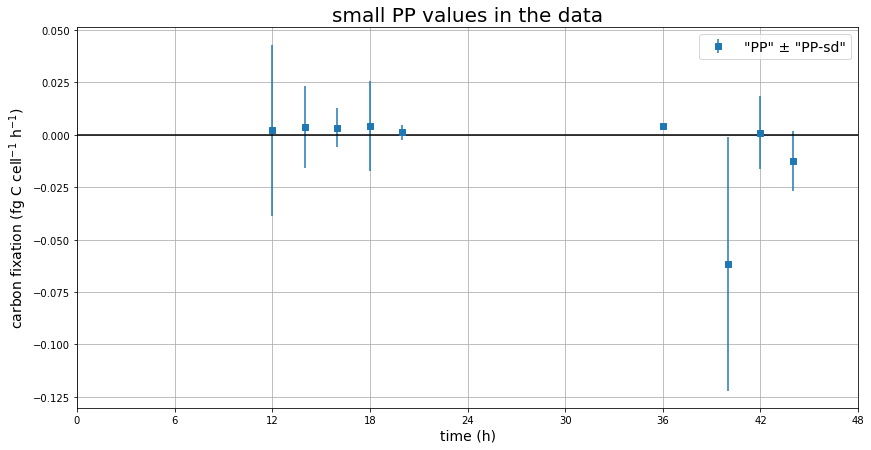

In [13]:
index_neg = zinser_fig3['PP'].values < 0.01

fig, ax = plt.subplots(figsize=(14,7))
ax.errorbar(obs_time_hours[index_neg], zinser_fig3['PP'].values[index_neg], yerr=zinser_fig3['PP-sd'].values[index_neg], ls='none', label='"PP" ± "PP-sd"', marker='s', color='tab:blue')
ax.axhline(0, color='black')
ax.legend()
ax.grid(True)
ax.set(ylabel='carbon fixation (fg C cell$^{-1}$ h$^{-1}$)')
ax.set(xlabel='time (h)', xticks=np.arange(0,50,6), title='small PP values in the data')
None

### propagate uncertainty

In [14]:
correct_negative_pp = True

In [15]:
pp = zinser_fig3['PP'].values

if correct_negative_pp:
    pp = np.maximum(pp, 0.0)

pp_sample_reportedsd = pp + zinser_fig3['PP-sd'].values[None,:] * np.random.normal(size=(num_samples, obs_time_hours.size))

c14_sample = pp_sample_reportedsd * abundance_mean
pp_sample = c14_sample/abundance_mean_sample

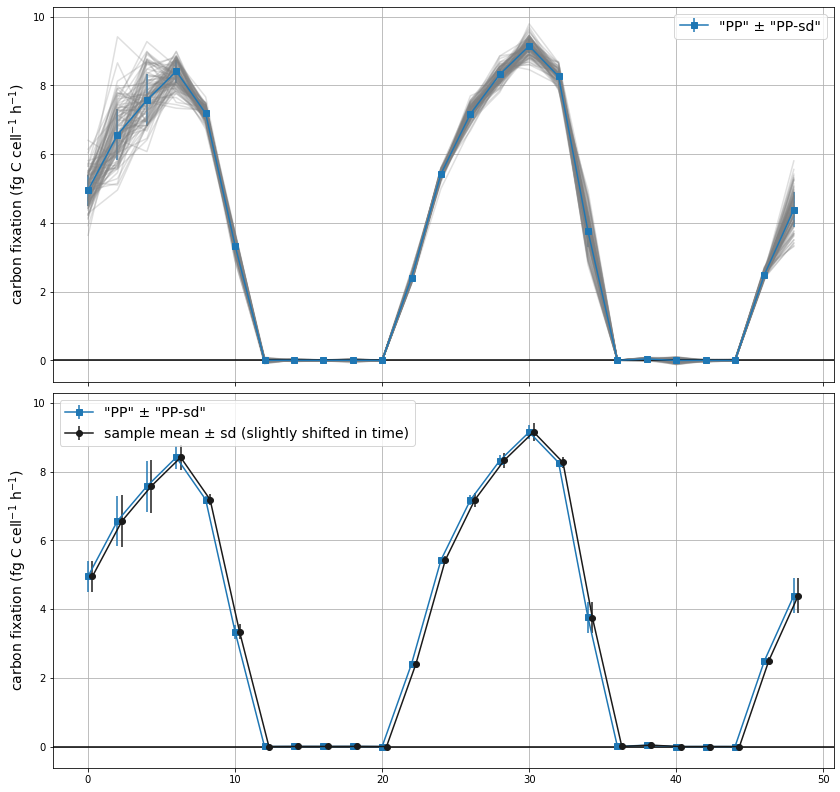

In [16]:
fig, axs = plt.subplots(nrows=2, figsize=(14,2*7), sharex=True, sharey=True, gridspec_kw={'hspace':0.03})
ax = axs[0]
ax.plot(obs_time_hours, pp_sample[:100,:].T, color='0.5', alpha=0.25)
ax.errorbar(obs_time_hours, pp, yerr=zinser_fig3['PP-sd'].values, label='"PP" ± "PP-sd"', marker='s', color='tab:blue')

ax = axs[1]
ax.errorbar(obs_time_hours, pp, yerr=zinser_fig3['PP-sd'].values, label='"PP" ± "PP-sd"', marker='s', color='tab:blue')
ax.errorbar(obs_time_hours+0.3, np.mean(pp_sample, axis=0), yerr=np.std(pp_sample, axis=0),
            marker='o', color='0.1', label='sample mean ± sd (slightly shifted in time)')

for ax in axs:
    ax.axhline(0, color='black')
    ax.legend()
    ax.grid(True)
    ax.set(ylabel='carbon fixation (fg C cell$^{-1}$ h$^{-1}$)')
None

### computing daily carbon fixation (based on `pp_sample` and `pp_sample_reportedsd`)

In [17]:
def compute_intfix(fix, time_hours):
    td = np.diff(time_hours)
    return 0.5 * np.sum(td * (fix[...,1:] + fix[...,:-1]), axis=-1) 

for sample, desc in ((pp_sample_reportedsd, 'reported standard deviation'), (pp_sample,'updated standard deviation')):

    daily_intfix = 0.5 * compute_intfix(sample, obs_time_hours)

    print('''
{}:
    avg daily carbon fixation (fg C /cell /d):
        sample: {:.3f} ± {:.3f} (mean ± sd)'''.format(
        desc,
        np.mean(daily_intfix), np.std(daily_intfix)))

    for iday in range(2):
        i0 = iday * 12
        i1 = (iday + 1) * 12 + 1
        daily_intfix = compute_intfix(sample[:,i0:i1], obs_time_hours[i0:i1])
        print('''
    carbon fixation day {}:
        sample: {:.3f} ± {:.3f} (mean ± sd)'''.format(
            iday + 1,
            np.mean(daily_intfix), np.std(daily_intfix)))

# to be used later
daily_intfix = 0.5 * compute_intfix(pp_sample_reportedsd, obs_time_hours)


reported standard deviation:
    avg daily carbon fixation (fg C /cell /d):
        sample: 84.767 ± 1.293 (mean ± sd)

    carbon fixation day 1:
        sample: 81.342 ± 2.285 (mean ± sd)

    carbon fixation day 2:
        sample: 88.193 ± 1.207 (mean ± sd)

updated standard deviation:
    avg daily carbon fixation (fg C /cell /d):
        sample: 84.800 ± 1.379 (mean ± sd)

    carbon fixation day 1:
        sample: 81.363 ± 2.372 (mean ± sd)

    carbon fixation day 2:
        sample: 88.237 ± 1.395 (mean ± sd)


# compute carbon loss (respiration + exudation)

### recreate previous values

In [18]:
# obtain more data
with nc4.Dataset('Zinser_SizeDist_logtransform-25-7.nc') as nc:
    w_obs = nc.variables['w_obs'][:]
    delta_v = 1.0/nc.variables['delta_v_inv'][:]
    v = nc.variables['v_min'][:].data * 2**(np.arange(nc.variables['m'][:])*delta_v)

**NOTE:**
We previously (incorrectly) computed
```
net = np.diff(biom) / (0.5 * (abundance_mean_uncorrected[:-1] + abundance_mean_uncorrected[1:]))
```
To account for the 2h difference between biom measurements, a factor of 0.5 needs to be introduced:
```
net = 0.5 * np.diff(biom) / (0.5 * (abundance_mean_uncorrected[:-1] + abundance_mean_uncorrected[1:]))
```
equivalent to 
```
net = np.diff(biom) / (abundance_mean_uncorrected[:-1] + abundance_mean_uncorrected[1:])
```

In [19]:
# "classic":
#
# based on Francois' proposed 
# BiomT1 = BiomT0 + dt * ([PP + Loss] * countT0)
# scheme 
#

w_obs2 = w_obs * abundance_mean_uncorrected[None,:]

#  calculate total biomass
biom = np.sum(v[:,None] * w_obs2, axis=0)

biom_smoothed = savgol_filter(biom, 5, 3)

net = np.diff(biom) / (abundance_mean_uncorrected[:-1] + abundance_mean_uncorrected[1:])
loss_classic = 0.5 * (zinser_fig3['PP'].values[:-1] + zinser_fig3['PP'].values[1:]) - net

net_smoothed = np.diff(biom_smoothed) / (abundance_mean_uncorrected[:-1] + abundance_mean_uncorrected[1:])
loss_classic_smoothed = 0.5 * (zinser_fig3['PP'].values[:-1] + zinser_fig3['PP'].values[1:]) - net_smoothed

# for plotting purposes, recompute wrong solution
loss_classic_wrong = 0.5 * (zinser_fig3['PP'].values[:-1] + zinser_fig3['PP'].values[1:]) - (
                     np.diff(biom_smoothed) / (0.5*(abundance_mean_uncorrected[:-1] + abundance_mean_uncorrected[1:])))

# "shifted pp"
#
# instead of computing PP at hours 1, 3, 5, ... using averaging, 
# assume that the PP is shifted from time 0, 2, 4, ... one hour forward
# do the same for abundance
#

net = 0.5 * np.diff(biom) / abundance_mean_uncorrected[:-1]
loss_shiftedpp = zinser_fig3['PP'].values[:-1] - net

net_smoothed = 0.5 * np.diff(biom_smoothed) / abundance_mean_uncorrected[:-1]
loss_shiftedpp_smoothed = zinser_fig3['PP'].values[:-1] - net_smoothed

# "cellsize-based"
#
# based on changes in cell size, rather than biomass
#

dt = obs_time_hours[1] - obs_time_hours[0]

# fg C cell-1
cellsize = np.sum(v[:,None] * w_obs, axis=0)
# fg C cell-1 h-1
net = (cellsize[1:]*(abundance_mean[1:]/abundance_mean[:-1]) - cellsize[:-1])/dt
loss_cellsizebased = zinser_fig3['PP'].values[1:] - net

# the time for all of the above

obs_time_loss = 0.5 * (obs_time_hours[1:] + obs_time_hours[:-1])

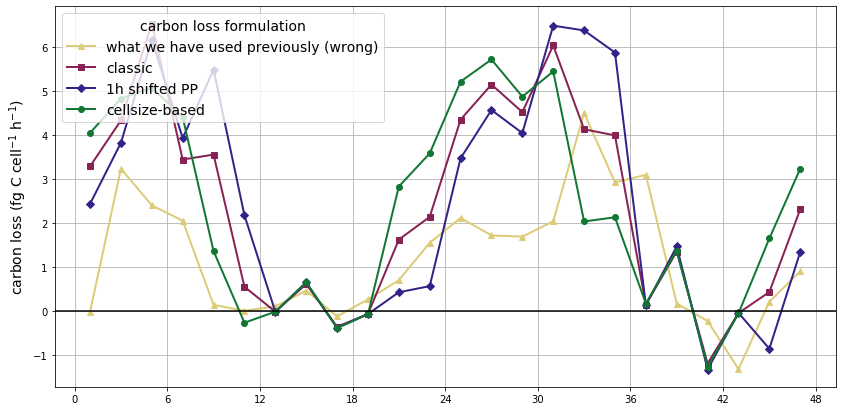

In [20]:
fig, ax = plt.subplots(figsize=(14,7))
ax.plot(obs_time_loss, loss_classic_wrong, lw=2, marker='^', color='#ddcc77', label='what we have used previously (wrong)')
ax.plot(obs_time_loss, loss_classic, lw=2, marker='s', color='#882255', label='classic')
ax.plot(obs_time_loss, loss_shiftedpp, lw=2, marker='D', color='#332288', label='1h shifted PP')
ax.plot(obs_time_loss, loss_cellsizebased, lw=2, marker='o', color='#117733', label='cellsize-based')
ax.set(ylabel='carbon loss (fg C cell$^{-1}$ h$^{-1}$)', xticks=np.arange(0,50,6))
ax.grid(True)
ax.legend(title='carbon loss formulation')
ax.axhline(0, color='black')
None

### propagate uncertainty

In [21]:
# select which of the 3 formulations above to use from here on
# 'classic', 'shiftedpp', 'cellsizebased'

loss_formulation = 'shiftedpp'

level 0:
   "net" mean sample sd: 0.632216484368784
level 1:
    "pp" mean sample sd: 0.16472464245140211
   "net" mean sample sd: 0.632216484368784
level 2:
    "pp" mean sample sd: 0.16472464245140211
   "net" mean sample sd: 0.6656349518117288


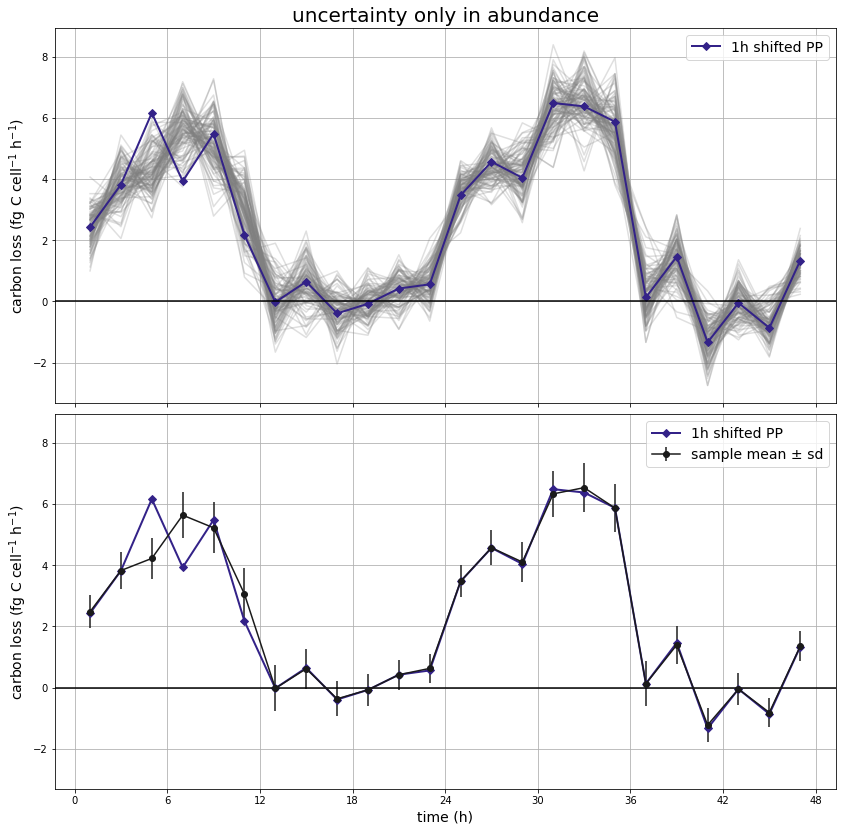

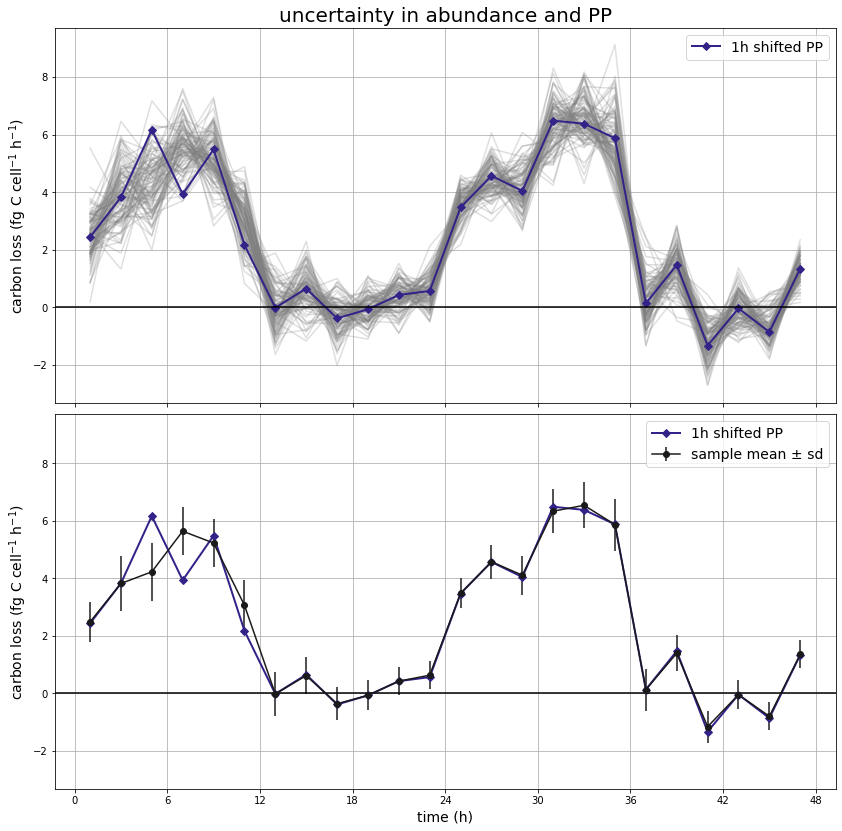

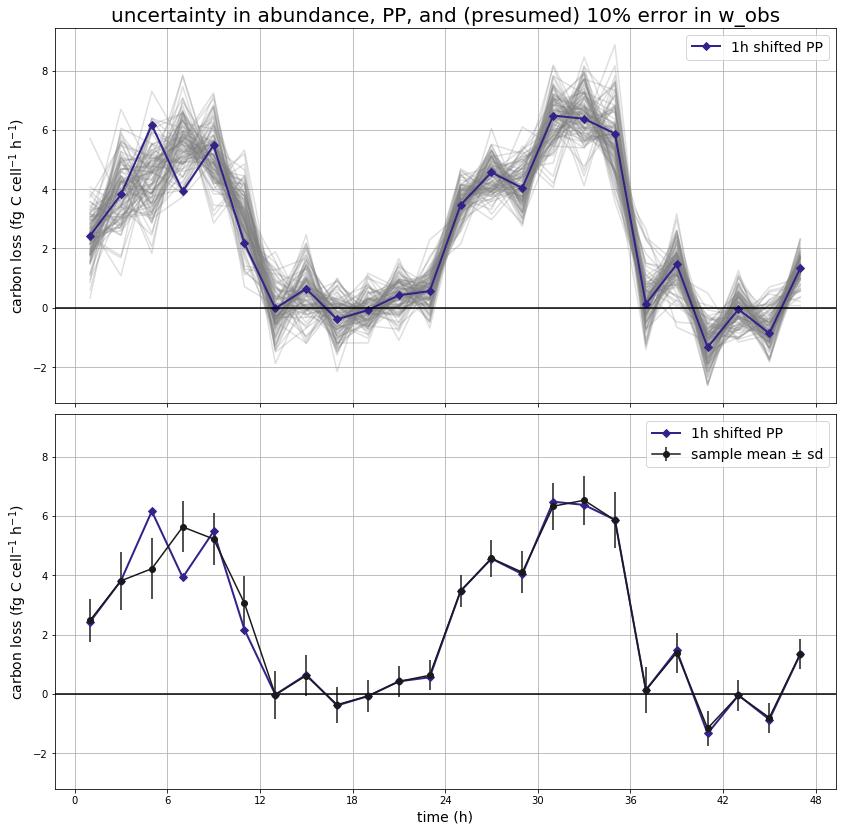

In [22]:
for level in range(3):
    print('level {}:'.format(level))
    # w_obs.shape: (25, 25) = (size, time)
    # abundance_mean_sample.shape: (10000, 25) = (num_samples, time)
    
    # compute net growth
    
    if level <= 1:
        w_obs2 = w_obs[None,:,:] * abundance_mean_sample[:,None,:]
        
        cellsize = np.sum(v[:,None] * w_obs, axis=0)[None,:]
    else:
        w_obs_sample = w_obs[None,:,:] + 0.1 * w_obs[None,:,:] * np.random.normal(size=(num_samples, w_obs.shape[0], w_obs.shape[1]))
        w_obs_sample = np.maximum(0.0, w_obs_sample)
        # re-normalize to 1
        w_obs_sample /= np.sum(w_obs_sample, axis=1)[:,None,:]
        w_obs2 = w_obs_sample * abundance_mean_sample[:,None,:]
        
        cellsize = np.sum(v[None,:,None] * w_obs_sample, axis=1)
    
    if loss_formulation == 'cellsizebased':
        net = (cellsize[:,1:] * (abundance_mean_sample[:,1:]/abundance_mean_sample[:,:-1]) - cellsize[:,:-1])/dt
    else:
        biom = np.sum(v[None,:,None] * w_obs2, axis=1)
        net = np.diff(biom, axis=1) / (abundance_mean_sample[:,:-1] + abundance_mean_sample[:,1:])
    
    # compute pp
    
    if level == 0:
        if loss_formulation == 'shiftedpp':
            pp = zinser_fig3['PP'].values[:-1]
        elif loss_formulation == 'cellsizebased':
            pp = zinser_fig3['PP'].values[1:]
        elif loss_formulation == 'classic':
            pp = 0.5 * (zinser_fig3['PP'].values[:-1] + zinser_fig3['PP'].values[1:])
        else:
            raise NotImplementedError('Loss formulation "{}" not yet implemented.'.format(loss_formulation))
    else:
        if loss_formulation == 'shiftedpp':
            pp = pp_sample_reportedsd[:,:-1]
        elif loss_formulation == 'cellsizebased':
            pp = pp_sample_reportedsd[:,1:]
        elif loss_formulation == 'classic':
            pp = 0.5 * (pp_sample_reportedsd[:,:-1] + pp_sample_reportedsd[:,1:])
        else:
            raise NotImplementedError('Loss formulation "{}" not yet implemented.'.format(loss_formulation))
        assert pp.shape[0] == num_samples
        print('    "pp" mean sample sd: {}'.format(np.mean(np.std(pp, axis=0))))
    
    # combine
    
    loss_sample = pp - net
    
    # IMPORTANT: determine what gets saved in data file at the end
    if level == 1:
        loss_sample_save = loss_sample.copy()
    
    print('   "net" mean sample sd: {}'.format(np.mean(np.std(net, axis=0))))
        
    if level == 0:
        description = 'uncertainty only in abundance'
    elif level == 1:
        description = 'uncertainty in abundance and PP'
    elif level == 2:
        description = 'uncertainty in abundance, PP, and (presumed) 10% error in w_obs'
    
    fig, axs = plt.subplots(nrows=2, figsize=(14,2*7), sharex=True, sharey=True, gridspec_kw={'hspace':0.03})

    ax = axs[0]
    ax.set_title(description)
    ax.plot(obs_time_loss, loss_sample[:100,:].T, color='0.5', alpha=0.25)
    if loss_formulation == 'shiftedpp':
        ax.plot(obs_time_loss, loss_shiftedpp, lw=2, marker='D', color='#332288', label='1h shifted PP')
    elif loss_formulation == 'classic':
        ax.plot(obs_time_loss, loss_classic, lw=2, marker='s', color='#882255', label='classic')
    elif loss_formulation == 'cellsizebased':
        ax.plot(obs_time_loss, loss_cellsizebased, lw=2, marker='o', color='#117733', label='cellsize-based')
    
    ax = axs[1]
    ax.set(xlabel='time (h)', xticks=np.arange(0,50,6))
    ax.errorbar(obs_time_loss, np.mean(loss_sample, axis=0), yerr=np.std(loss_sample, axis=0), 
                marker='o', color='0.1', label='sample mean ± sd')
    if loss_formulation == 'shiftedpp':
        ax.plot(obs_time_loss, loss_shiftedpp, lw=2, marker='D', color='#332288', label='1h shifted PP')
    elif loss_formulation == 'classic':
        ax.plot(obs_time_loss, loss_classic, lw=2, marker='s', color='#882255', label='classic')
    elif loss_formulation == 'cellsizebased':
        ax.plot(obs_time_loss, loss_cellsizebased, lw=2, marker='o', color='#117733', label='cellsize-based')
    
    for ax in axs:
        ax.axhline(0, color='black')
        ax.legend()
        ax.grid(True)
        ax.set(ylabel='carbon loss (fg C cell$^{-1}$ h$^{-1}$)')

### computing daily carbon loss (based on `loss_sample_save`)

In [23]:
def compute_intloss(loss, time_hours):
    td = np.diff(time_hours)
    return 0.5 * np.sum(td * (loss[...,1:] + loss[...,:-1]), axis=-1) 

for iday in range(2):
    i0 = iday * 12
    i1 = (iday + 1) * 12 + 1
    daily_intloss = compute_intloss(loss_sample_save[:,i0:i1], obs_time_loss[i0:i1])
    print('''
carbon loss day {}:
    sample: {:.3f} ± {:.3f} (mean ± sd)'''.format(
        iday + 1,
        np.mean(daily_intloss), np.std(daily_intloss)))

daily_intloss = 0.5 * compute_intloss(loss_sample_save, obs_time_loss)

print('''
avg daily carbon loss (fg C /cell /d):
    sample: {:.3f} ± {:.3f} (mean ± sd)'''.format(
    np.mean(daily_intloss), np.std(daily_intloss)))


carbon loss day 1:
    sample: 52.274 ± 2.444 (mean ± sd)

carbon loss day 2:
    sample: 58.652 ± 1.360 (mean ± sd)

avg daily carbon loss (fg C /cell /d):
    sample: 55.463 ± 1.338 (mean ± sd)


# save results to netCDF

In [24]:
import netCDF4 as nc4

fname = 'zinser_abundance_division_loss.nc'

save_data = False

if save_data:
    with nc4.Dataset(fname, 'w') as nc:
        # first save some global attributes
        nc.setncatts({
            'created_by':'propagate_uncertainty.ipynb',
            'correct_abundance_mean':int(correct_abundance_mean),
            'scale_error_with_signal':int(scale_error_with_signal),
            'loss_formulation':loss_formulation,
        })

        #
        # abundance
        #

        nc.createDimension('abundance_time', obs_time_hours.size)

        var = nc.createVariable('abundance_time', int, ('abundance_time',))
        var[:] = obs_time_hours
        var.units = 'hours since start of experiment'

        var = nc.createVariable('abundance', float, ('abundance_time',))
        var[:] = np.mean(abundance_mean_sample, axis=0)
        var.long_name = 'cell abundance'
        var.units = 'cells ml$^{-1}$'

        var = nc.createVariable('abundance_sd', float, ('abundance_time',))
        var[:] = np.std(abundance_mean_sample, axis=0)
        var.long_name = 'standard deviation of cell abundance'
        var.units = 'cells ml$^{-1}$'

        #
        # division
        #

        nc.createDimension('division_time', obs_time_division.size)

        var = nc.createVariable('division_time', int, ('division_time',))
        var[:] = obs_time_division.astype('int')
        var.units = 'hours since start of experiment'

        var = nc.createVariable('division', float, ('division_time',))
        var[:] = np.mean(division_sample, axis=0)
        var.long_name = 'cell division rate'
        var.units = 'h$^{-1}$'

        var = nc.createVariable('division_sd', float, ('division_time',))
        var[:] = np.std(division_sample, axis=0)
        var.long_name = 'standard deviation of cell division rate'
        var.units = 'h$^{-1}$'

        # daily

        var = nc.createVariable('dailydivision', float, fill_value=False)
        var[:] = np.mean(daily_division_sample)
        var.long_name = 'mean daily cell division rate'
        var.units = 'd$^{-1}$'

        var = nc.createVariable('dailydivision_sd', float, fill_value=False)
        var[:] = np.std(daily_division_sample)
        var.long_name = 'standard deviation of daily cell division rate'
        var.units = 'd$^{-1}$'

        #
        # carbon loss
        #

        nc.createDimension('carbonloss_time', obs_time_loss.size)

        var = nc.createVariable('carbonloss_time', int, ('carbonloss_time',))
        var[:] = obs_time_loss.astype('int')
        var.units = 'hours since start of experiment'

        var = nc.createVariable('carbonloss', float, ('carbonloss_time',))
        var[:] = np.mean(loss_sample_save, axis=0)
        var.long_name = 'cell carbon loss rate'
        var.units = 'fg C cell$^{-1}$ h$^{-1}$'

        var = nc.createVariable('carbonloss_sd', float, ('carbonloss_time',))
        var[:] = np.std(loss_sample_save, axis=0)
        var.long_name = 'standard deviation of cell carbon loss rate'
        var.units = 'fg C cell$^{-1}$ h$^{-1}$'

        # daily

        var = nc.createVariable('dailycarbonloss', float, fill_value=False)
        var[:] = np.mean(daily_intloss)
        var.long_name = 'mean daily cell carbon loss rate'
        var.units = 'fg C cell$^{-1}$ d$^{-1}$'

        var = nc.createVariable('dailycarbonloss_sd', float, fill_value=False)
        var[:] = np.std(daily_intloss)
        var.long_name = 'standard deviation of daily cell carbon loss rate'
        var.units = 'fg C cell$^{-1}$ d$^{-1}$'

        #
        # carbon fixation
        #

        nc.createDimension('carbonfix_time', obs_time_hours.size)

        var = nc.createVariable('carbonfix_time', int, ('carbonfix_time',))
        var[:] = obs_time_hours.astype('int')
        var.units = 'hours since start of experiment'

        var = nc.createVariable('carbonfix', float, ('carbonfix_time',))
        var[:] = np.mean(pp_sample, axis=0)
        var.long_name = 'cell carbon fixation rate'
        var.units = 'fg C cell$^{-1}$ h$^{-1}$'

        var = nc.createVariable('carbonfix_sd', float, ('carbonfix_time',))
        var[:] = np.std(pp_sample, axis=0)
        var.long_name = 'standard deviation of cell carbon fixation rate'
        var.units = 'fg C cell$^{-1}$ h$^{-1}$'

        # daily

        var = nc.createVariable('dailycarbonfix', float, fill_value=False)
        var[:] = np.mean(daily_intfix)
        var.long_name = 'mean daily cell carbon fixation rate'
        var.units = 'fg C cell$^{-1}$ d$^{-1}$'

        var = nc.createVariable('dailycarbonfix_sd', float, fill_value=False)
        var[:] = np.std(daily_intfix)
        var.long_name = 'standard deviation of daily cell carbon fixation rate'
        var.units = 'fg C cell$^{-1}$ d$^{-1}$'